# Toxic Comment Classification 

***Weikai Mao*** *(wm282)*

In this project, I need to create a model to predict the probability of each type of toxicity for each comment. The dataset includes the Wikipedia comments which have been labeled for toxic behavior (toxic, severe_toxic, obscene, threat, insult, identity_hate).

The data is in csv format. There are 8 columns: id (string), identity_hate (integer), toxic (integer),
severe_toxi (integer), obscene (integer), threat (integer), insult (integer), and comment_text (string).
The feature id is useless, so I dropt it.
Apart from id and comment_text , the other 6 features indicate whether this comment text is labeled for
the corresponding toxic behavior.

## 1. Data analysis



Since I cannot use Spark and Pyspark in Colab, I redo some important analyses here by using Numpy and Pandas. Please read my intermediate report for the data analyses by using Spark.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras import layers, initializers, optimizers, \
                  constraints, regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Input, Activation, LSTM, Dense,\
                         Dropout, GlobalMaxPool1D, Bidirectional, CuDNNLSTM

### 1.1 Import data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge"

In [ ]:
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')
sentences_tr = train.iloc[:, 1].values
Ytr = train.iloc[:, 2:].values
sentences_te = test.iloc[:, 1].values

The variable `commen_text` contains the sentences that are use to train the prediction model to do classification. The other 6 variables show the labels of these sentences, and most of them are 0, which means there are not toxic languages.

In [ ]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 1.2 Descriptive statistics

The table below is the descriptive statistics of the trainin data. It shows that the frequency of toxic in comments is highest, whereas the frequency of threat is lowest.

In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.3 Correlation matrix

One comment can be classified to several classes. These labels can be correlated with each other. The plot below is the correlation matrix of these labels. 

From the charts below, we can see that either two of `toxic`, `obscene`, and `insult` have high correlation.

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


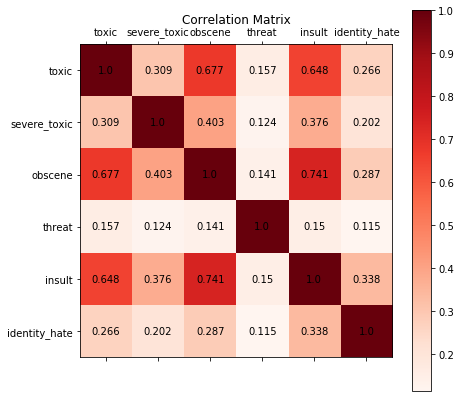

In [ ]:
corr_df = train[train.columns[:]].corr()
display(corr_df)

plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()
im = ax.imshow(corr_df)
im = ax.matshow(corr_df, cmap=plt.cm.Reds)
# Loop over data dimensions and create text annotations.
for i in range(len(corr_df)):
    for j in range(len(corr_df)):
        text = ax.text(j, i, round(corr_df.iloc[i, j], 3), \
        ha="center", va="center")

# labels
labels = list(corr_df.columns)
labels.insert(0, "")
ax.set_xticklabels(labels, minor=False)
ax.set_yticklabels(labels, minor=False)
ax.figure.colorbar(im, ax=ax)
ax.set_title("Correlation Matrix")
plt.show()

## 2. Preprocessing

### 2.1 Tokenization

This is specially for LSTM. I use the tokenizer to split the sentences into words. I set the number of unique words in our dictionary as 10000. 

After spliting a sentence to a sequence of words, I convert these words to a sequence of index.

For example, 

sentence: "this is the final project"

-> sequence of words: ["this", "is", "the", "final", "project"]

-> sequence of indexes: [1, 2, 3, 4, 5]




In [ ]:
maxUniqueWords = 10000
tokenizer = Tokenizer(num_words=maxUniqueWords)
tokenizer.fit_on_texts(sentences_tr)
tokenized_tr = tokenizer.texts_to_sequences(sentences_tr)
tokenized_te = tokenizer.texts_to_sequences(sentences_te)

### 2.2 Zero-padding

This is specially for LSTM. 

Different sentences have different lengths, I need to convert them to the same length to make it is practical to train the neural network model. For a short sentence, I use the zero-padding to make them have the same length as others. For a long sentence, I trim them. 

For example, if the standard length is 7, then the sequence of indexs [1, 2, 3, 4, 5] will be zero-padded as [0, 0, 1, 2, 3, 4, 5]. 

I use the function `pad_sequences()` to do this operation, there is a parameter `maxlen`, which is the standard length of all sentences after zero-padding. If this pramameter is too large, trianing the neural network model will be too computationally expensive. On the other hand, if it is too small, I will lose much information in the long sentences. 

To decide this paramter, I plot a histgram as below. As shown in the plot below, most sentences are very short. I select the parameter `maxlen` as 200.

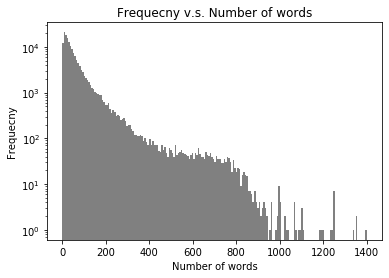

In [ ]:
lenList = list(map(len, tokenized_tr))
plt.hist(lenList, bins=200, facecolor="grey", alpha=1, histtype='bar')
plt.yscale("log")
plt.ylabel('Frequecny')
plt.xlabel('Number of words')
plt.title('Frequecny v.s. Number of words');

In [ ]:
maxSentenceLen = 100
Xtr = pad_sequences(tokenized_tr, maxlen=maxSentenceLen)
Xte = pad_sequences(tokenized_te, maxlen=maxSentenceLen)
Xtr

array([[   0,    0,    0, ..., 4583, 2273,  985],
       [   0,    0,    0, ...,  589, 8377,  182],
       [   0,    0,    0, ...,    1,  737,  468],
       ...,
       [   0,    0,    0, ..., 8167, 3509, 4528],
       [   0,    0,    0, ...,  151,   34,   11],
       [   0,    0,    0, ..., 1627, 2056,   88]], dtype=int32)

### 2.3 TF-IDF vectorization

If term $t$ occurs in $n(t)$ out of $N$ documents, and term $t$ occurs $\text{Count}(t,d)$ times in the document $d$, then TF-IDF formula for term $t$ in the document $d$ can be expressed as: 

$$
\text{tfidf}(t,d) = \text{tf}(t,d) \cdot \text{idf}(t) = \log_{10}[1+\text{Count}(t,d)] \cdot \log_{10} [\frac{N}{n(t)}].
$$


In [ ]:
tfidfVec1 = TfidfVectorizer(sublinear_tf=True,
                           strip_accents='unicode',
                           stop_words='english',
                           lowercase=True,
                           ngram_range=(1, 1))

tfidfVec1.fit(train["comment_text"])
Xtr_tfidf1 = tfidfVec1.transform(train["comment_text"])
Xte_tfidf1 = tfidfVec1.transform(test["comment_text"])

In [ ]:
tfidfVec2 = TfidfVectorizer(sublinear_tf=True,
                           strip_accents='unicode',
                           stop_words='english',
                           lowercase=True,
                           ngram_range=(1, 2))

tfidfVec2.fit(train["comment_text"])
Xtr_tfidf2 = tfidfVec2.transform(train["comment_text"])
Xte_tfidf2 = tfidfVec2.transform(test["comment_text"])

## 3. Naive Bayes

Formula: 

$$
c_{NB} = \underset{c \in C}{\operatorname{argmax}} \log P(c) + \sum_{i\in \text{positions}} \log P(w_i|c),
$$

where $c$ is a a class, $C$ is the number of all classes, and $w_i$ is the word at index $i$.

In [ ]:
# define the accuracy function
def accuracy(y:np.array, yhat:np.array) -> float:
    yhat[yhat >= 0.5] = 1
    yhat[yhat < 0.5] = 0
    return 1 - np.mean(np.abs(y-yhat))

submission = pd.read_csv(path + "/sample_submission.csv")
scores = pd.DataFrame(np.zeros(shape=(3,7)), columns=list(train.columns)[2:]+["average"], \
                      index=["cross entropy loss", "accuracy", "auc"])

In [ ]:
# build naive bayes models for each class
for label in train.columns[2:]:
    nb = MultinomialNB()
    nb.fit(Xtr_tfidf2, train[label])
    Yhat_tr = nb.predict_proba(Xtr_tfidf2)[:, 1]
    submission.loc[:, label] = nb.predict_proba(Xte_tfidf2)[:, 1]

    scores.loc["cross entropy loss", label] = log_loss(train[label], Yhat_tr)
    scores.loc["auc", label] = roc_auc_score(train[label], Yhat_tr)
    scores.loc["accuracy", label] = accuracy(train[label].values, np.copy(Yhat_tr))

submission.to_csv(path + "/submission_nb.csv", index=False)

The table below shows the cross-entropy loss, accuracy and ROC AUC of naive Bayes model for each class in training data set.

In [18]:
scores["average"] = np.mean(scores.iloc[:, :5], axis=1)
scores

,toxic,severe_toxic,obscene,threat,insult,identity_hate,average
cross entropy loss,0.294577,0.067734,0.204334,0.028244,0.209467,0.067256,0.160871
accuracy,0.913543,0.990004,0.949897,0.997004,0.951244,0.991195,0.960339
auc,0.924955,0.915966,0.919677,0.847005,0.914673,0.868693,0.904455


The prediction score (ROC AUC) in test set evaluted by Kaggle is 0.81913.

## 4. Logistic regression

Formula:

$$
y = \text{Sigmoid}(z) = \frac{1}{1+e^{-z}}, \\z = Xw + b,
$$

where $X$ is of dimension $n\times p$; $w$ is of $p\times 1$; $b$ is $n\times 1$; $z$ and $y$ are $n\times 1$.

Since there are 6 classes, I need to build 6 seperate logistic regression models.

In [ ]:
# build logistic regression models for each class
for label in train.columns[2:]:
    lr = LogisticRegression()
    lr.fit(Xtr_tfidf2, train[label])
    Yhat_tr = lr.predict_proba(Xtr_tfidf2)[:, 1]
    submission.loc[:, label] = lr.predict_proba(Xte_tfidf2)[:, 1]

    scores.loc["cross entropy loss", label] = log_loss(train[label], Yhat_tr)
    scores.loc["auc", label] = roc_auc_score(train[label], Yhat_tr)
    scores.loc["accuracy", label] = accuracy(train[label].values, np.copy(Yhat_tr))

submission.to_csv(path + "/submission_lr.csv", index=False)

The table below shows the cross-entropy loss, accuracy and ROC AUC of logistic regression for each class in training data set.

In [ ]:
scores["average"] = np.mean(scores.iloc[:, :5], axis=1)
scores

,toxic,severe_toxic,obscene,threat,insult,identity_hate,average
cross entropy loss,0.101256,0.023906,0.054709,0.009685,0.069640,0.023101,0.051839
accuracy,0.961766,0.991352,0.979708,0.997218,0.973115,0.992292,0.980632
auc,0.986006,0.992861,0.994158,0.995825,0.988808,0.991235,0.991532


The prediction score (ROC AUC) in test set evaluted by Kaggle is 0.97595.

## 5. Random forest

Random forest is a tree emsemble method and it can dramatically reduce the variance of the model compared to single decision tree.

In [ ]:
for label in train.columns[2:]:
    treeCount, max_features = 10, int(Xtr_tfidf1.shape[1]**0.5)
    rf = RandomForestClassifier(max_features=max_features, min_samples_leaf=0.0001, n_estimators=treeCount)
    rf.fit(Xtr_tfidf1, np.ravel(train[label]))
    Yhat_tr = rf.predict_proba(Xtr_tfidf1)[:, 1]
    submission.loc[:, label] = rf.predict_proba(Xte_tfidf1)[:, 1]

    scores.loc["cross entropy loss", label] = log_loss(train[label], Yhat_tr)
    scores.loc["auc", label] = roc_auc_score(train[label], Yhat_tr)
    scores.loc["accuracy", label] = accuracy(train[label].values, np.copy(Yhat_tr))

submission.to_csv(path + "/submission_rf.csv", index=False)

The table below shows the cross-entropy loss, accuracy and ROC AUC of random forest for each class in training data set.

In [42]:
scores["average"] = np.mean(scores.iloc[:, :5], axis=1)
scores

,toxic,severe_toxic,obscene,threat,insult,identity_hate,average
cross entropy loss,0.164773,0.029456,0.102225,0.011024,0.103707,0.029520,0.082237
accuracy,0.937733,0.990004,0.956916,0.997004,0.957379,0.991201,0.967807
auc,0.963565,0.985580,0.977778,0.992431,0.973112,0.980085,0.978493


The prediction score (ROC AUC) in test set evaluted by Kaggle is 0.95805.

## 6. XGBoost

XGBoost is a popular tree emsemble model based on boosting trees. 

At $m^{th}$ step, we want to minimize the objective 

$$
Obj^{(m)} = \sum_{i=1}^{n}L(y_i, f_{m-1}(x)+h_m(x_i)) + \Omega(f_{m-1}+h_{m}),
$$
then $h_m = \operatorname*{argmin}_{h_m} Obj^{(m)}$. 

In the formula above, $\Omega(f_m)$ is the **regularization** term, which is used to measure the complexity of $f_m$. 
$$
\Omega(f_m) = \mu T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2,
$$
where $T$ is the number of leaves, $w_j$ is the prediction score of leaf $j$, and $\sum_{j=1}^{T} w_j^2$ is the L2 norm of leaf scores. 

We use **second order Taylor expansion** to get the approximation of loss function. Recall Taylor expansion: $f(x+\Delta x) \approx f(x)+f'(x)\Delta x + \frac{1}{2} f''(x)\Delta x^2$. We do that for $L(y_i, f_{m-1}(x)+h_m(x_i))$, and we have

$$\begin{align*}
Obj^{(m)} &= \sum_{i=1}^{n}L(y_i, f_{m-1}(x)+h_m(x_i)) + \Omega(f_{m-1}) + \Omega(h_{m})\\ 
&\approx \sum_{i=1}^{n} \Big[L(y_i, f_{m-1}(x)) + g_ih_m(x_i) + \frac{1}{2}h_ih_m^2(x_i)\Big] + \Omega(f_{m-1}) + \Omega(h_{m}),
\end{align*}$$

where $g_i = \frac{∂L(y_i,f_{m-1}(x_i))}{∂f_{m-1}(x_i)}, h_i = \frac{∂L^2(y_i,f_{m-1}(x_i))}{∂f_{m-1}^2(x_i)}$. 

Here is a brief description of XGBoost algorithm:
For $m = 1,...,M$:

1. $$\begin{align*}
   h_m = \operatorname*{argmin}_{h_m} Obj^{(m)} = \operatorname*{argmin}_{h_m} \Big[g_ih_m(x_i) + \frac{1}{2}h_ih_m^2(x_i)\Big] + \Omega(h_{m}).
   \end{align*}$$

2. $$\begin{align*}
   f_m(x) = f_{m−1}(x) + s_m \cdot h_m(x),
   \end{align*}$$ where $s_m$ is called step-size or shrinkage, usually set around $0.1$. 

The **shrinkage** means we do not do full optimization in each step and reserve chance for future rounds, it helps prevent overfitting. 

Regularization, second order Taylor expansion, and shrinkage are the key reasons why XGBoost is better than Gradient boosting. 

In [ ]:
for label in train.columns[2:]:
    xgb = XGBClassifier(min_samples_leaf=0.00001, learning_rate=0.1, 
                        n_estimators=50, eval_metric="auc")
    xgb.fit(Xtr_tfidf1, np.ravel(train[label]))
    Yhat_tr = xgb.predict_proba(Xtr_tfidf1)[:, 1]
    submission.loc[:, label] = xgb.predict_proba(Xte_tfidf1)[:, 1]

    scores.loc["cross entropy loss", label] = log_loss(train[label], Yhat_tr)
    scores.loc["auc", label] = roc_auc_score(train[label], Yhat_tr)
    scores.loc["accuracy", label] = accuracy(train[label].values, np.copy(Yhat_tr))

submission.to_csv(path + "/submission_xgb.csv", index=False)

In [55]:
scores["average"] = np.mean(scores.iloc[:, :5], axis=1)
scores

,toxic,severe_toxic,obscene,threat,insult,identity_hate,average
cross entropy loss,0.210161,0.033305,0.100495,0.014026,0.119545,0.033461,0.095507
accuracy,0.931686,0.990518,0.970653,0.997299,0.961785,0.992035,0.970388
auc,0.869150,0.942195,0.927468,0.896759,0.900400,0.907127,0.907194


The prediction score (ROC AUC) in test set evaluted by Kaggle is 0.91208.

## 7. LSTM model

The neural networks perform much better than other models like n-gram language models. In network, word embeddings are used to represent the previous words, rather than the exact words that are used in n-gram models. It follows that the neural network models can predict based on some contexts that are even unseen in the training data. 

### 7.1 Input layer

This layer accepts the indexs of the words.

In [ ]:
inp = Input(shape=(maxSentenceLen, ))

### 7.2 Embedding layer

If I convert all the indexs of words into ont-hot vectors, the dimension will be too large. The word embedding is a good way to solve this problem. The intuition is that we can encode our words to a $D$-dimensional space, and each dimension may represent one meaning. For example, maybe there is a dimension that represent the size: huge, big, medium, small and tiny etc. 

One way is using the pretrained word embeddings (such as GloVe). However, a better way is adding a embedding layer in the RNN (or LSTM), and train the word embeddings while training the network, it is better because these embeddings are specifically trained for the task.

In [ ]:
embeddingSize = 100
wordEmbed = Embedding(input_dim=maxUniqueWords, output_dim=embeddingSize)(inp)

### 7.3 LSTM layer

LSTM can capture long-term dependencies by deciding what to remember and forget in its layers. There are six components:

$$
\text{Input gate: } i_t = \sigma (W^{(i)}x_t + U^{(i)}h_{t-1}), \\\text{Forget gate: } f_t = \sigma (W^{(f)}x_t + U^{(f)}h_{t-1}), \\\text{Output/Exposure gate: } o_t = \sigma (W^{(o)}x_t + U^{(o)}h_{t-1}), \\\text{New memory cell: } \tilde{c}_t = \text{tanh}(W^{(c)}x_t + U^{(c)}h_{t-1}), \\\text{Final memory cell: } c_t = f_t \cdot c_{t-1} + i_t \cdot \tilde{c}_t, \\ \text{Output:} h_t = o_t \cdot \text{tanh}(c_t).
$$


![alt text](https://github.com/WalkerMao/Notes/blob/master/Pictures/image-20191214001943088.png?raw=true) 

[Source: CS224n notes.](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes05-LM_RNN.pdf)

In [ ]:
outputDim = 50
lstm = Bidirectional(LSTM(units=outputDim, return_sequences=True, dropout=0.3, \
                          recurrent_dropout=0.3))(wordEmbed)

### 7.4 Maximum pooling layer

I use this layer to reduce the dimension and apply the drop-out for regularization, and to reduce the overfitting. 

In [ ]:
lstm = GlobalMaxPool1D()(lstm)
lstm = Dropout(rate=0.3)(lstm)

### 7.5 Fully connected layer

The activation function used here is ReLU.

$$
\text{ReLU: } \sigma(z)=\max(z,0).
$$

The gradient vannishing is not a severe problem for this function, so it is better than sigmoid and tanh. This layer is fully connected with the previous layer, and I also apply the drop-out to reduce over-fitting.

In [ ]:
fc = Dense(units=50, activation="relu")(lstm)
fc = Dropout(rate=0.3)(fc)

### 7.6 Sigmoid layer

In this problem, one observation may be classified to several classes, so I should not use the softmax function. The function used is this layer is sigmoid, since I need to predict the probability of each class, which is between 0 and 1.

$$
\text{Sigmoid: }\sigma(z)=\frac{1}{1+e^{-z}}.
$$

The output dimension is 6 since there are 6 classes. 

In [ ]:
out = Dense(units=6, activation="sigmoid")(fc) 

### 7.7 Construct the model

The architure of this model:

```
Input -> [Input layer] -> [Embedding layer] ->  [LSTM layer] -> [Maximum pooling layer] -> [Fully connected layer] -> [Sigmoid layer] -> Output
```

For this classification problem, the loss function is the cross entropy loss:

**Cross-entropy loss** function for $K$-class classification: 

$$
\text{Loss}(y_i, \hat{p}_i) = -\sum_{k=1}^{K} I(y_i \text{ in class } k)\log(\hat{p}_{ik}),
$$

where $\hat{p}_{ik}$ is the estimated probability of $y_i$ belongs to class $k$. For binary classification, $L(y_i, \hat{p}_i) = -y_i\log(\hat{p}_i) - (1-y_i)\log(1-\hat{p}_i)$, where $y_i\in\{0,1\}$, $\hat{p}_i$ is the estimated probability of $y_i=1$.

The partial derivative of the cross entropy loss:

$$
\frac{\partial \text{Loss}} {\partial \hat{p}_{ik}} = \frac{y_{ik}}{\hat{p}_{ik}}.
$$

In [ ]:
model = Model(inputs=inp, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 7.8 Training

Training the LSTM model, with the batch size of 100 and different epochs. To see the validation error and accuracy, I use 10% of the training data set as the validation set. 

I have tried different epochs and recorded the the number of epochs and the corresponding error and accuracy, as shown in the table below.

In [ ]:
batch_size = 100
epochs = 5
model.fit(Xtr, Ytr, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:
val = pd.DataFrame([[0.0425,0.9840,0.0460,0.9826],
                    [0.0391,0.9848,0.0459,0.9829],
                    [0.0362,0.9857,0.0477,0.9827],
                    [0.0335,0.9866,0.0498,0.9820],
                    [0.0312,0.9874,0.0539,0.9823]])
val.columns = ["Training loss", "Training accuracy", "Validaton loss", "Validation accuracy"]
val

,Training loss,Training accuracy,Validaton loss,Validation accuracy
0,0.0425,0.9840,0.0460,0.9826
1,0.0391,0.9848,0.0459,0.9829
2,0.0362,0.9857,0.0477,0.9827
3,0.0335,0.9866,0.0498,0.9820
4,0.0312,0.9874,0.0539,0.9823


From the plots below, we can see that the validation loss is lowest when `epochs=2`, and the validation accuracy is highest for the same parameter value. However, the training loss keeps decreasing and training accuracy keeps increasing.

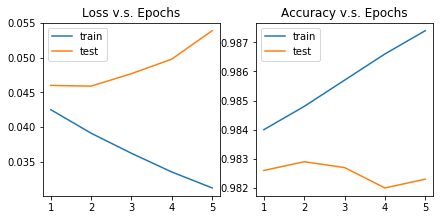

In [ ]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(range(1,6), val[["Training loss", "Validaton loss"]])
plt.title("Loss v.s. Epochs")
plt.legend(['train', "test"]);
plt.subplot(2,2,2)
plt.plot(range(1,6), val[["Training accuracy", "Validation accuracy"]])
plt.title("Accuracy v.s. Epochs")
plt.legend(['train', "test"]);

This model tends to be overfitting for large number of epochs. It follows that `epochs=2` is the best parameter I should select. For the final model, all data is used for training and there is no validation set.

In [ ]:
batch_size = 100
epochs = 2
model.fit(Xtr, Ytr, batch_size=batch_size, epochs=epochs, validation_split=0)

Epoch 1/2
159571/159571 [==============================] - 557s 3ms/step - loss: 0.0424 - acc: 0.9839
Epoch 2/2
159571/159571 [==============================] - 553s 3ms/step - loss: 0.0394 - acc: 0.9846


### 7.9 Summary of the model

The table below is the summary of this model, and there are 1,031,916 parameters in total.

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 50)           30200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0   

### 7.10 Prediction

Predict the probabilities on the test data set. The prediction score evaluted by Kaggle is 0.96736.

In [ ]:
Yhat_te = model.predict(Xte)

In [ ]:
submission = pd.read_csv(path + "/sample_submission.csv")
submission.iloc[:, 1:] = Yhat_te
submission.to_csv(path + "/submission_lstm.csv", index=False)

## 8. Related work

For this toxic language classification preblem, some combinations such as shallow learners with deep neural networks are especially effective (van Aken, Betty, et al., 2018). Capsule networks with dynamic routing can outperfroms LSTM. In adddition, capsule networks show significant improvement when transferring single-label to multi-label text classifications over strong baseline methods (Zhao et al., 2018). However, these models are too computationally expensive to implement for my final project. I want to build a model that have a good prediction performance and is computationally affordable.


**References:**

van Aken, Betty, et al. "Challenges for toxic comment classification: An in-depth error analysis." arXiv preprint arXiv:1809.07572 (2018).

Zhao, Wei, et al. "Investigating capsule networks with dynamic routing for text classification." arXiv preprint arXiv:1804.00538 (2018).


## 9. Results and conclusion

The average prediction scores on 6 classes:

| Model | Cross entropy (train)| Accuracy (train) | ROC AUC (train) | ROC AUC (test) |
|---|---|---|---|---|
|Naive Bayes| 0.1609 | 0.9603 | 0.9045 | 0.81913 |
|Logistic regression| 0.0518 | 0.9806 | **0.9915** |**0.97595** |
| Random forest | 0.0822 | 0.9678 | 0.9785 | 0.95805 |
|XGBoost| 0.0955 | 0.9603 | 0.9072 | 0.91208 |
| LSTM | **0.0394**	 | **0.9846** | 0.9821 |0.96736 |

We can see that the logistic regression is the best model since it has the highest ROC AUC in the test data set. 

LSTM usually performs better than other n-gram models since it can handle much longer memories, and they can generalize better over similar words by using word embeddings.

However, in this classification problem, I do not need to have long memories since one or two key words are enough for the model to do classification. I think that is why logistic regression with 2 gram is better than LSTM.

## 10. Acknowledgments

### 10.1 Data set

From Kaggle: [Toxic Comment Classification Challenge.](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data.)

### 10.2 Libraries

`pyspark`, `numpy`, `pandas`, `matplotlib`, `sklearn`, `xgboost`, `keras`.

### 10.3 References

Jurafsky, Daniel and James H. Martin. *Speech and Language Processing (3 rd ed.)*. 2019.

Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. *The Elements of Statistical Learning*. Vol. 1. No. 10. New York: Springer series in statistics, 2001. 

Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." *Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining*. ACM, 2016.

[CS224n: NLP with DL. Lecture Notes: Part V. Language Models, RNN, GRU and LSTM.](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes05-LM_RNN.pdf)

van Aken, Betty, et al. "Challenges for toxic comment classification: An in-depth error analysis." arXiv preprint arXiv:1809.07572 (2018).

Zhao, Wei, et al. "Investigating capsule networks with dynamic routing for text classification." arXiv preprint arXiv:1804.00538 (2018).